<a href="https://colab.research.google.com/github/Kryptera-K/EFA-ADX-Compression-AO-Downshift-Strategy/blob/main/EFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "EFA"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("EFA_clean.csv", index=False)
df

/tmp/ipython-input-1074214627.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2001-08-27,22.604342,22.648320,22.565641,22.648320,44700
2001-08-28,22.345758,22.472412,22.303539,22.446026,319800
2001-08-29,22.243736,22.410850,22.217348,22.402054,128400
2001-08-30,21.927105,21.988674,21.865538,21.988674,36900
2001-08-31,21.979870,22.015051,21.883119,21.918301,1656900
...,...,...,...,...,...
2025-11-21,92.650002,92.900002,91.760002,92.099998,27211400
2025-11-24,92.730003,92.879997,92.339996,92.449997,18550900
2025-11-25,93.839996,93.879997,92.889999,93.129997,19903700


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

ADX_LEVEL = 20
ADX_PERIOD = 14
ADX_SHIFT = 5
AO_CHANGE_SHIFT_1 = 5
AO_CHANGE_SHIFT_2 = 10
AO_LEVEL = 5
AO_LONG_PERIOD = 34
AO_SHORT_PERIOD = 5
ROC_LEVEL = 0
ROC_PERIOD = 10
ROC_SHIFT = 5
STOCHASTIC_D_PERIOD = 3
STOCHASTIC_K_PERIOD = 14
STOCHASTIC_OVERBOUGHT = 80
STOCHASTIC_OVERSOLD = 20

# -------------------------
# Indicator Functions
# -------------------------

def adx_is_falling(df, period=ADX_PERIOD):
    df = calculate_adx(df, period)
    return df['ADX'].diff() < 0


def calculate_adx(df, period=14):
    """
    Calculate ADX and related columns.
    """

    # True Range (TR)
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    # Directional Movement (DM)
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    # Smoothed values
    df['TRn'] = df['TR'].rolling(window=period).sum()
    df['+DMn'] = df['+DM'].rolling(window=period).sum()
    df['-DMn'] = df['-DM'].rolling(window=period).sum()

    # Calculate +DI and -DI
    df['+DI'] = 100 * (df['+DMn'] / df['TRn'])
    df['-DI'] = 100 * (df['-DMn'] / df['TRn'])

    # DX and ADX
    df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window=period).mean()

    return df


def ao_change_direction_downward(df, short_period=AO_SHORT_PERIOD, long_period=AO_LONG_PERIOD, shift1=AO_CHANGE_SHIFT_1, shift2=AO_CHANGE_SHIFT_2):
    df = calculate_ao(df, short_period, long_period)
    return (df['AO'].shift(shift1) < df['AO'].shift(shift2)) & (df['AO'] < df['AO'].shift(shift1))


def calculate_ao(df, short_period=AO_SHORT_PERIOD, long_period=AO_LONG_PERIOD):
    """
    Calculate Awesome Oscillator (AO)
    df : pandas DataFrame with ['High', 'Low']
    short_period : short SMA (default 5)
    long_period : long SMA (default 34)
    """
    df = df.copy()
    df["MedianPrice"] = (df["High"] + df["Low"]) / 2
    df["SMA_short"] = df["MedianPrice"].rolling(window=short_period, min_periods=1).mean()
    df["SMA_long"] = df["MedianPrice"].rolling(window=long_period, min_periods=1).mean()
    df['AO'] = df["SMA_short"] - df["SMA_long"]
    return df


def slow_d_falling(df):
    df = calculate_stochastic(df)
    return df['Slow_%D'].diff() < 0


def calculate_stochastic(df, k_period=STOCHASTIC_K_PERIOD, d_period=STOCHASTIC_D_PERIOD):
    """Calculate Fast %K and Slow %D"""
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()

    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(window=d_period).mean()
    return df


def roc_cross_above_level(df, level=ROC_LEVEL):
    df = calculate_roc(df)
    return (df['ROC'].shift(1) <= level) & (df['ROC'] > level)


def calculate_roc(df, period=ROC_PERIOD):
    """
    Calculate Rate of Change (ROC) for Close prices.
    """
    df = df.copy()
    df['ROC'] = (df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100
    return df



# -------------------------
# Entry conditions
# -------------------------

df["ADX_Falling"] = adx_is_falling(df)
df["AO_Change_Downward"] = ao_change_direction_downward(df)

# -------------------------
# Exit conditions
# -------------------------

df["Stochastic_Slow_%D_Falling"] = slow_d_falling(df)
df["ROC_Cross_Above_Level"] = roc_cross_above_level(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'ADX_Falling',
    'AO_Change_Downward',
]
exit_conditions = [
    'Stochastic_Slow_%D_Falling',
    'ROC_Cross_Above_Level',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2001-08-27 00:00:00
End                                  2025-11-28 00:00:00
Period                                6101 days 00:00:00
Start Value                                     100000.0
End Value                                  564500.300673
Total Return [%]                              464.500301
Benchmark Return [%]                          318.750687
Max Gross Exposure [%]                             100.0
Total Fees Paid                             39543.815932
Max Drawdown [%]                               41.450943
Max Drawdown Duration                  692 days 00:00:00
Total Trades                                          79
Total Closed Trades                                   78
Total Open Trades                                      1
Open Trade PnL                              -1694.629903
Win Rate [%]                                   57.692308
Best Trade [%]                                 37.709799
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2001-08-27 00:00:00
End                           2025-11-28 00:00:00
Period                         6101 days 00:00:00
Start Value                              100000.0
End Value                            418750.68717
Total Return [%]                       318.750687
Benchmark Return [%]                   318.750687
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        60.933342
Max Drawdown Duration          1669 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                       318750.68717
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-3649098280.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


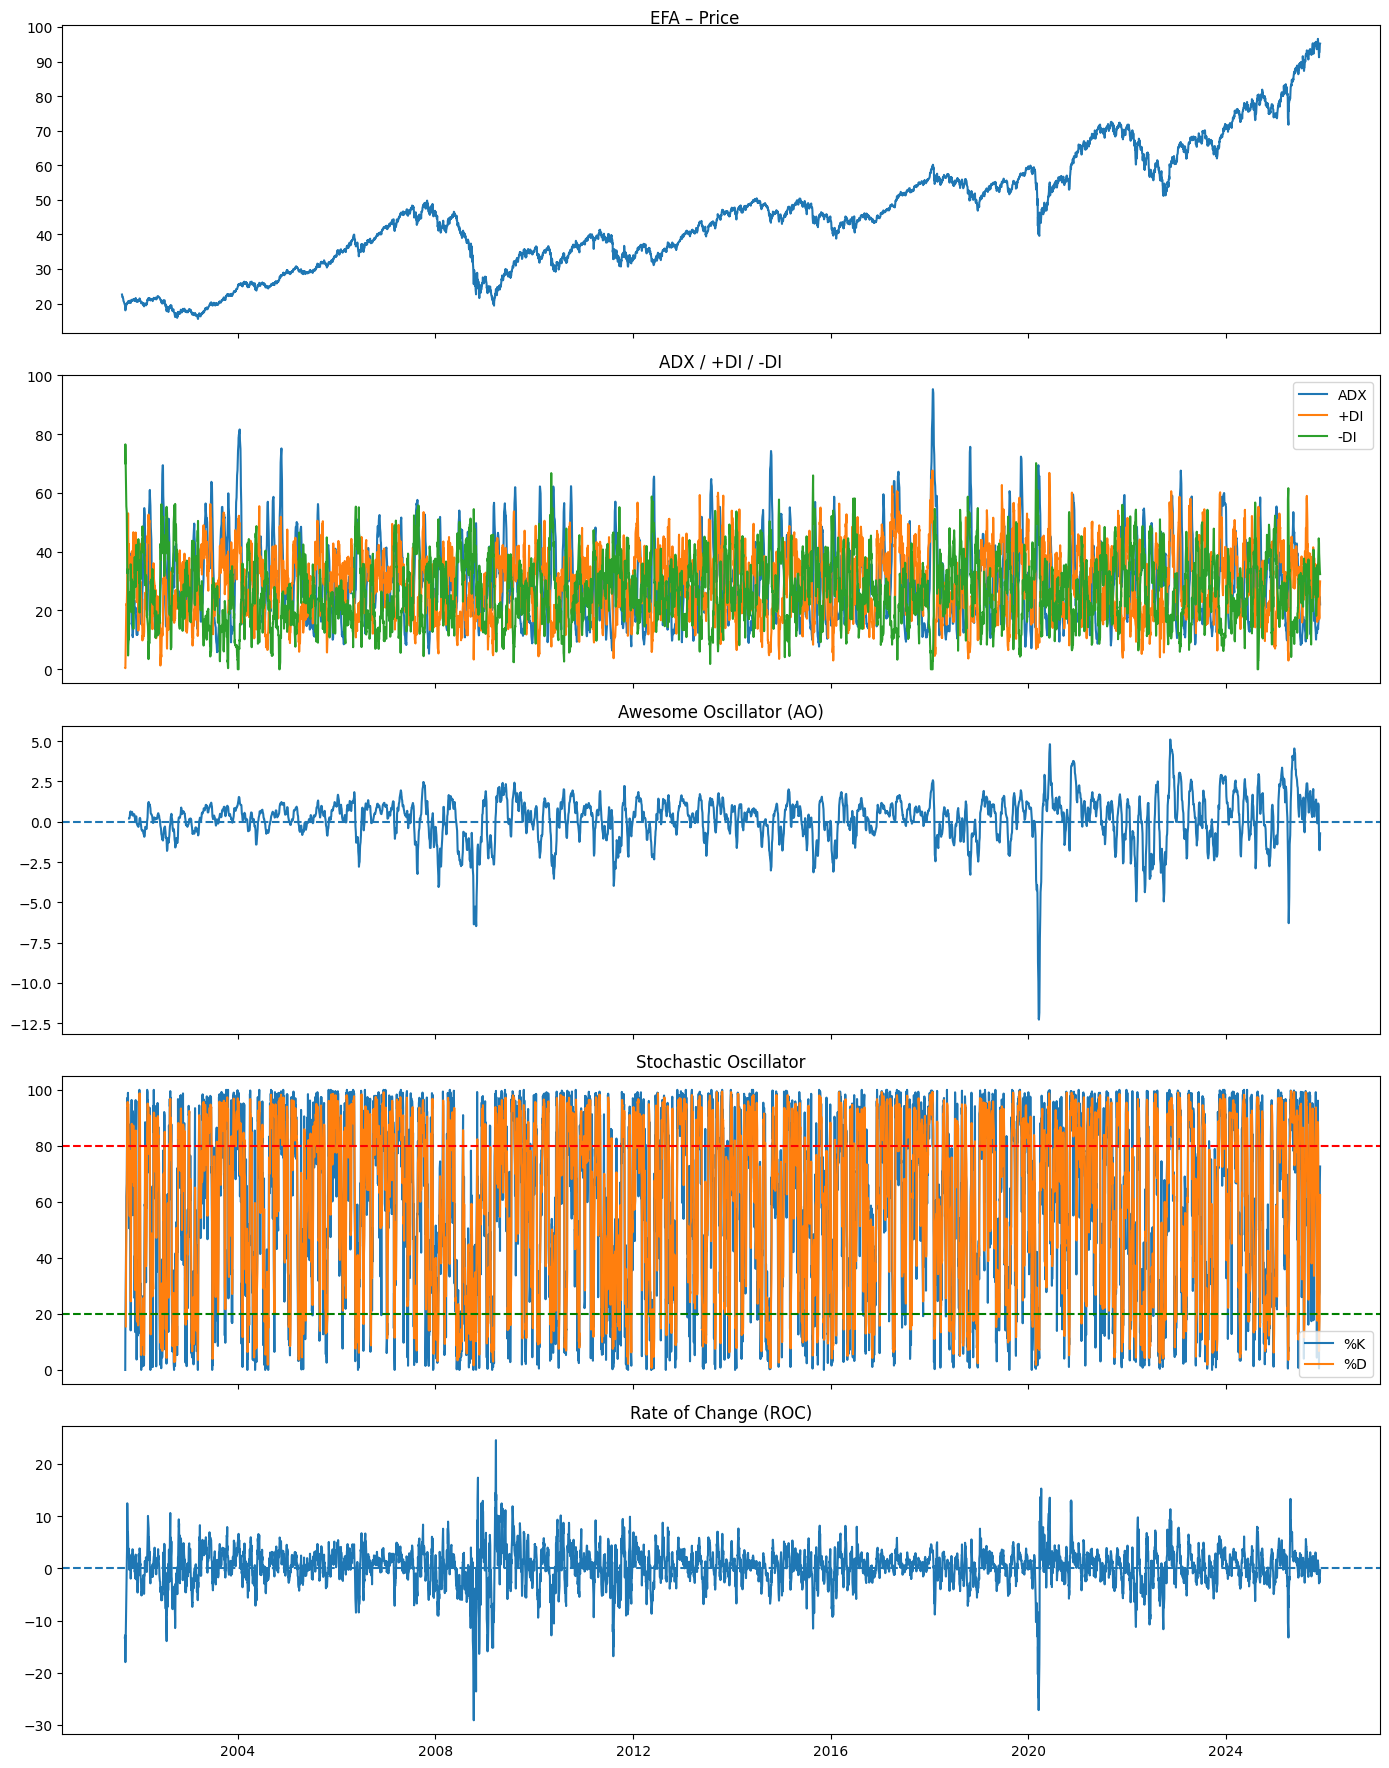

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "EFA"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Parameters
# -------------------------

ADX_PERIOD = 14
AO_SHORT_PERIOD = 5
AO_LONG_PERIOD = 34
STOCHASTIC_K_PERIOD = 14
STOCHASTIC_D_PERIOD = 3
ROC_PERIOD = 10

# -------------------------
# Indicator Calculations
# -------------------------

def calculate_adx(df, period=14):
    df = df.copy()

    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) >
                         (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)

    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) >
                         (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TRn'] = df['TR'].rolling(window=period).sum()
    df['+DMn'] = df['+DM'].rolling(window=period).sum()
    df['-DMn'] = df['-DM'].rolling(window=period).sum()

    df['+DI'] = 100 * (df['+DMn'] / df['TRn'])
    df['-DI'] = 100 * (df['-DMn'] / df['TRn'])

    df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window=period).mean()

    return df


def calculate_ao(df, short_period=5, long_period=34):
    df = df.copy()
    df["MedianPrice"] = (df["High"] + df["Low"]) / 2
    df["SMA_short"] = df["MedianPrice"].rolling(short_period).mean()
    df["SMA_long"] = df["MedianPrice"].rolling(long_period).mean()
    df["AO"] = df["SMA_short"] - df["SMA_long"]
    return df


def calculate_stochastic(df, k_period=14, d_period=3):
    df = df.copy()
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()

    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(window=d_period).mean()

    return df


def calculate_roc(df, period=10):
    df = df.copy()
    df['ROC'] = (df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100
    return df


# -------------------------
# Apply Indicators
# -------------------------

df = calculate_adx(df, ADX_PERIOD)
df = calculate_ao(df, AO_SHORT_PERIOD, AO_LONG_PERIOD)
df = calculate_stochastic(df, STOCHASTIC_K_PERIOD, STOCHASTIC_D_PERIOD)
df = calculate_roc(df, ROC_PERIOD)

# -------------------------
# Plotting
# -------------------------

fig, axs = plt.subplots(5, 1, figsize=(14, 18), sharex=True)
fig.suptitle(f"{symbol} – Price", fontsize=12)

# 1. Price
axs[0].plot(df.index, df['Close'])

# 2. ADX
axs[1].plot(df.index, df['ADX'], label="ADX")
axs[1].plot(df.index, df['+DI'], label="+DI")
axs[1].plot(df.index, df['-DI'], label="-DI")
axs[1].legend()
axs[1].set_title("ADX / +DI / -DI")

# 3. AO
axs[2].plot(df.index, df['AO'])
axs[2].axhline(0, linestyle="--")
axs[2].set_title("Awesome Oscillator (AO)")

# 4. Stochastic
axs[3].plot(df.index, df['Fast_%K'], label="%K")
axs[3].plot(df.index, df['Slow_%D'], label="%D")
axs[3].axhline(80, color='red', linestyle='--')
axs[3].axhline(20, color='green', linestyle='--')
axs[3].legend()
axs[3].set_title("Stochastic Oscillator")

# 5. ROC
axs[4].plot(df.index, df['ROC'])
axs[4].axhline(0, linestyle='--')
axs[4].set_title("Rate of Change (ROC)")

plt.tight_layout()
plt.show()
